In [1]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

## Reading the Files

### Broad Band

In [2]:
#Observation 
result_b_1 = fits.open('acisf16177_000N022_r0044b_lc3.fits')
print(result_b_1.info())
resolution_b_1 = result_b_1[1].header['TIMEDEL']
print(f'Time resolution_1 = {resolution_b_1} s')
date_start_1 = result_b_1[1].header['DATE-OBS']
date_end_1 = result_b_1[1].header['DATE-END']
print(f'Observation Timeline : {date_start_1} to {date_end_1}\n\n')

Filename: acisf16177_000N022_r0044b_lc3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    163   6411R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    169   6411R x 5C   [1D, 1D, 1D, 1D, 1D]   
None
Time resolution_1 = 19.979912877083 s
Observation Timeline : 2014-10-08T21:30:03 to 2014-10-10T09:35:33




## Extracting the Data

In [3]:
%matplotlib inline
#OBSERVATION 1
lc_b_1 = result_b_1[1].data #Lightcurve
bg_b_1 = result_b_1[2].data #Lightcurve

#arrays
time_b_1 = lc_b_1['Time']
count_rate_b_1 = lc_b_1['COUNT_RATE']
count_rate_err_b_1 = lc_b_1['COUNT_RATE_ERR']

bg_count_rate_b_1 = bg_b_1['COUNT_RATE']
bg_count_rate_err_b_1 = bg_b_1['COUNT_RATE_ERR']

net_count_rate_b_1 = count_rate_b_1 - bg_count_rate_b_1
net_err_b_1 = [(count_rate_err_b_1[i]**2 + bg_count_rate_err_b_1[i]**2)**0.5 for i in range(len(bg_count_rate_b_1))]

#starting time from zero
dt_b_1 = time_b_1 - time_b_1[0]

## Representing the Data

### Broad Band

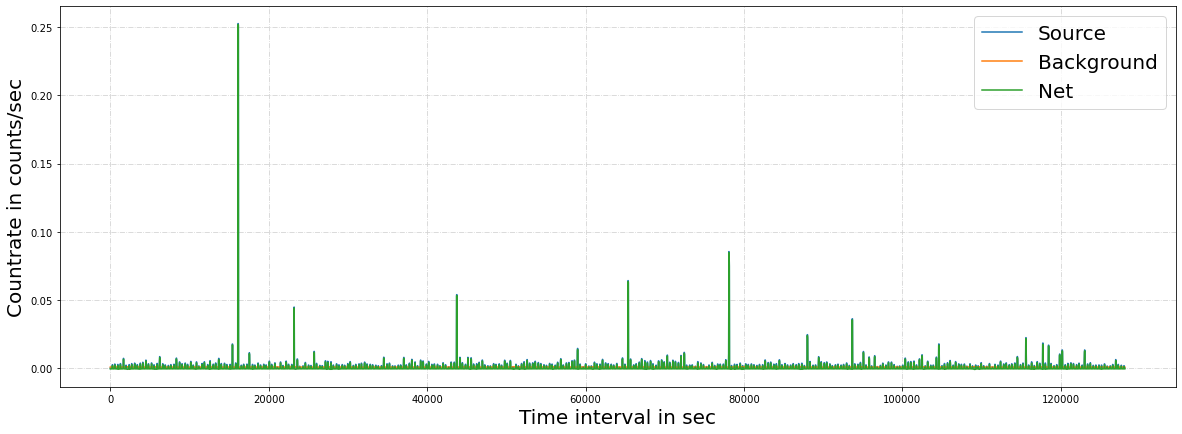

In [4]:
plt.figure(figsize = [20,7], facecolor = 'w')
plt.plot(dt_b_1, count_rate_b_1, label = 'Source')
plt.plot(dt_b_1, bg_count_rate_b_1, label = 'Background')
plt.plot(dt_b_1, net_count_rate_b_1, label = 'Net')
#plt.errorbar(dt_b_1,count_rate_b_1, count_rate_err_b_1)
plt.grid(color = 'lightgrey', ls = '-.')
plt.xlabel('Time interval in sec', fontsize = 20)
plt.ylabel('Countrate in counts/sec', fontsize =20)
#plt.title(f'plot of {file_name}', fontsize = 20)
#plt.text(10000,2.8e-5, s = f'resolution = {resolution} s', fontsize = 20)
#plt.xlim(0,40000)
#plt.ylim(-0.005,0.005)
plt.legend(fontsize = 20)

## Binning the Data


Binned resolution is 199.79912877082998s


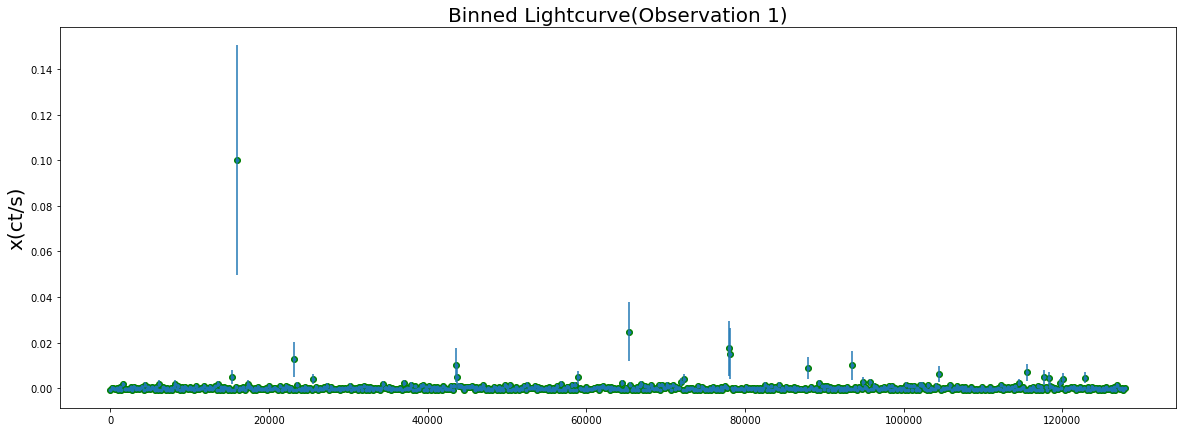

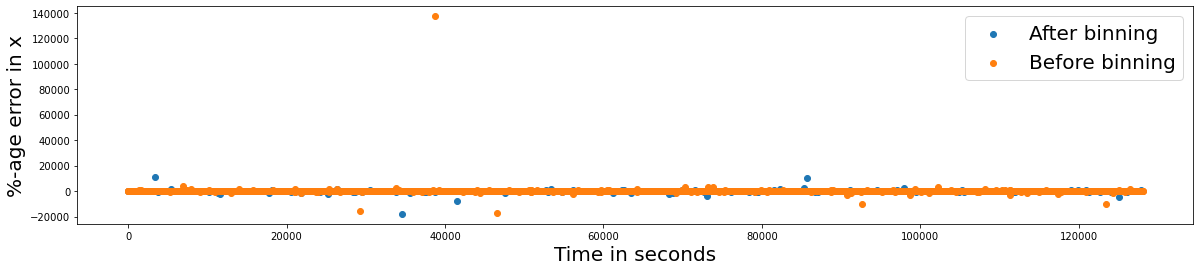

In [5]:
n_total_b_1 = 6411 #Total data points
n_bin_b_1 = 641#Number of bins
bin_size_b_1 = int(n_total_b_1/n_bin_b_1) #Bin size in units of data points
binned_resolution_b_1 = bin_size_b_1*resolution_b_1
print(f'Binned resolution is {binned_resolution_b_1}s')

cr_binned_b_1= np.zeros(n_bin_b_1)
t_binned_b_1= np.zeros(n_bin_b_1)
err_binned_b_1 = np.zeros(n_bin_b_1)

for i in range(n_bin_b_1):
    t_binned_b_1[i] = dt_b_1[bin_size_b_1*i]
for i in range(n_bin_b_1):
    sum_err_sq = 0
    for j in range((bin_size_b_1)):
        #summing and averaging all the counts 
        cr_binned_b_1[i] += net_count_rate_b_1[j+i*bin_size_b_1]/bin_size_b_1
        #summing square errors
        sum_err_sq += net_err_b_1[j+i*bin_size_b_1]**2 
    err_binned_b_1[i] = (sum_err_sq/bin_size_b_1**2)**0.5 

#Percentage error before and after binning
err_percent_binned_b_1 = []
err_percent_b_1 = []
for i in range(n_bin_b_1):
    err_percent_binned_b_1.append((err_binned_b_1[i]/cr_binned_b_1[i])*100)
for i in range(n_total_b_1):
    err_percent_b_1.append((net_err_b_1[i]/net_count_rate_b_1[i])*100)
    
plt.figure(figsize = [20,7], facecolor = 'w')
plt.scatter(t_binned_b_1,cr_binned_b_1,c='green')
plt.errorbar(t_binned_b_1, cr_binned_b_1, err_binned_b_1,fmt = '.')
plt.title('Binned Lightcurve(Observation 1)', fontsize = 20)
plt.ylabel('x(ct/s)', fontsize = 20)
#plt.ylim(0,0.002)
plt.figure(figsize = [20,4], facecolor = 'w')
plt.scatter(t_binned_b_1,err_percent_binned_b_1, label = 'After binning')
plt.scatter(dt_b_1[:n_total_b_1],err_percent_b_1, label = 'Before binning')
#plt.ylim(9.3,11)
plt.ylabel('%-age error in x', fontsize = 20)
plt.xlabel('Time in seconds', fontsize = 20)
plt.legend(fontsize = 20)


## Removing Outliers

In [6]:
cr_binned_deleted = []
t_deleted = []
for i in range(len(cr_binned_b_1)):
    if cr_binned_b_1[i] < 0.02:
        cr_binned_deleted.append(cr_binned_b_1[i])
        t_deleted.append(t_binned_b_1[i])
        
cr_binned_b_1 = cr_binned_deleted
t_binned_b_1  = t_deleted
len(cr_binned_b_1)

639

## Statistics from the Data

/tmp/ipykernel_11642/1295449974.py:33: RuntimeWarning: invalid value encountered in double_scalars
  F_var.append((Nxs_var[i]**0.5)*100)


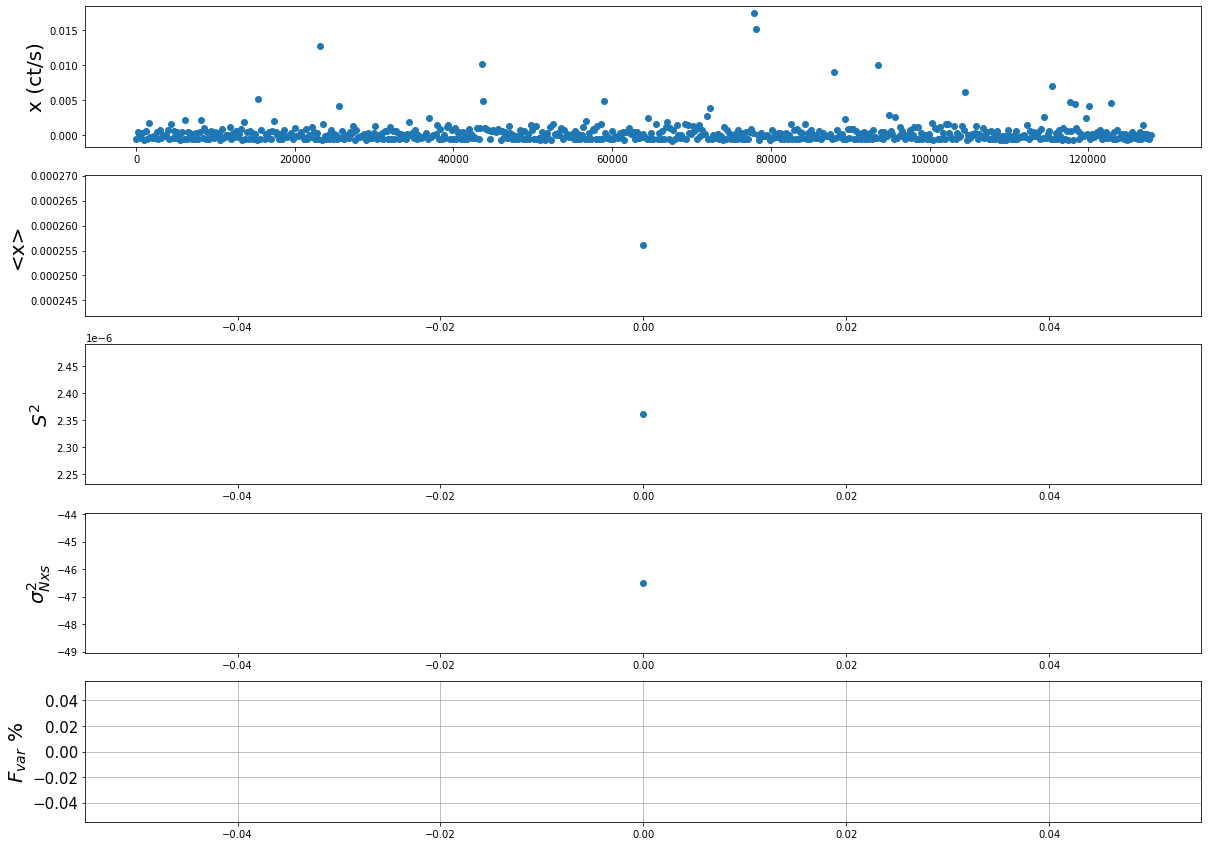

In [7]:
#MAKING AVG FLUX OF EVERY 20 POINTS
n_binned = 639#Total data points(already binned)
bin_size = 639#size of the bin in data points
n_points = int(n_binned/bin_size) #no. of data points

#print(n_points)
t_avg = [] #time for avg count of 20
c_avg = [] #avg count rate on 20 points bin
for i in range(n_points):
    t_avg.append(t_binned_b_1[i*bin_size])
    #print(i,i*25)
    sum = 0
    for j in range(bin_size):
        sum += cr_binned_b_1[j+i*bin_size]
    c_avg.append(sum/bin_size)
    
var = [] #variance
xs_var = [] #excess variance
Nxs_var = [] #Normalized excess variance
F_var = []
for i in range(n_points):
    sum = 0
    sum_err_sq = 0 #sum of squared err
    for j in range(0,bin_size):
        sum += (cr_binned_b_1[j+i*bin_size] - c_avg[i])**2
        sum_err_sq += (err_binned_b_1[j+i*bin_size])**2
    avg_sum_err_sq = sum_err_sq/bin_size
    #print('err ',avg_sum_err_sq)
    #print('var ',sum/19)
    var.append(sum/(bin_size - 1))
    xs_var.append(var[i] - avg_sum_err_sq)
    Nxs_var.append(xs_var[i]/c_avg[i]**2)
    F_var.append((Nxs_var[i]**0.5)*100)
#EXPECTATION VALUE OF VARIANCE
'''
expect_var = []
t_further = []
for i in range(7):
    sum = 0
    t_further.append(t_avg[i*20])
    for j in range(20):
        sum += var[j+i*20]
    expect_var.append(sum/20)
'''    
#PLOTTING
plt.figure(figsize = [20,15])
ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)
ax1.scatter(t_binned_b_1, cr_binned_b_1)
ax1.set_ylabel('x (ct/s)', fontsize = 20)
ax2.scatter(t_avg, c_avg)
ax2.set_ylabel('<x>', fontsize = 20)
ax3.scatter(t_avg, var)
ax3.set_ylabel('$S^2$', fontsize = 20)
y = plt.yticks(fontsize = 15)
#ax3.set_yscale('log')
ax4.scatter(t_avg, Nxs_var)
ax4.set_ylabel('$σ_{Nxs}^2$', fontsize = 20)
plt.grid(True)
y = plt.yticks(fontsize = 15)
ax5.scatter(t_avg, F_var)
ax5.set_ylabel('$F_{var} $ %', fontsize = 20)
y = plt.yticks(fontsize = 15)
ax5.grid(True)
#plt.ylim(0,50)

## Histogram of count rate


### Observation 3


/tmp/ipykernel_12312/1318947175.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(cr_binned_b_1), bins = 25)


(array([ 2.,  0.,  0.,  1.,  1.,  3.,  5.,  4.,  6.,  9., 18., 16., 31.,
        30., 44., 41., 32., 28., 10.,  7.,  4.,  6.,  1.,  3.,  3.]),
 array([-5.42974209, -5.2828521 , -5.1359621 , -4.98907211, -4.84218212,
        -4.69529213, -4.54840214, -4.40151214, -4.25462215, -4.10773216,
        -3.96084217, -3.81395218, -3.66706218, -3.52017219, -3.3732822 ,
        -3.22639221, -3.07950221, -2.93261222, -2.78572223, -2.63883224,
        -2.49194225, -2.34505225, -2.19816226, -2.05127227, -1.90438228,
        -1.75749229]),
 <BarContainer object of 25 artists>)

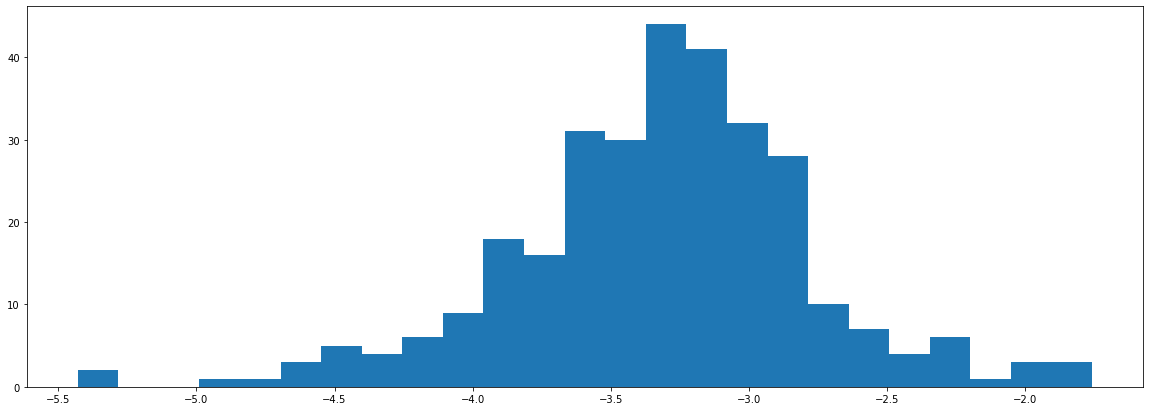

In [50]:
plt.figure(figsize = [20,7])
plt.hist(np.log10(cr_binned_b_1), bins = 25)
#plt.xscale('logit')

Goodness of fit for Gaussian 11.517278261831558 per dof


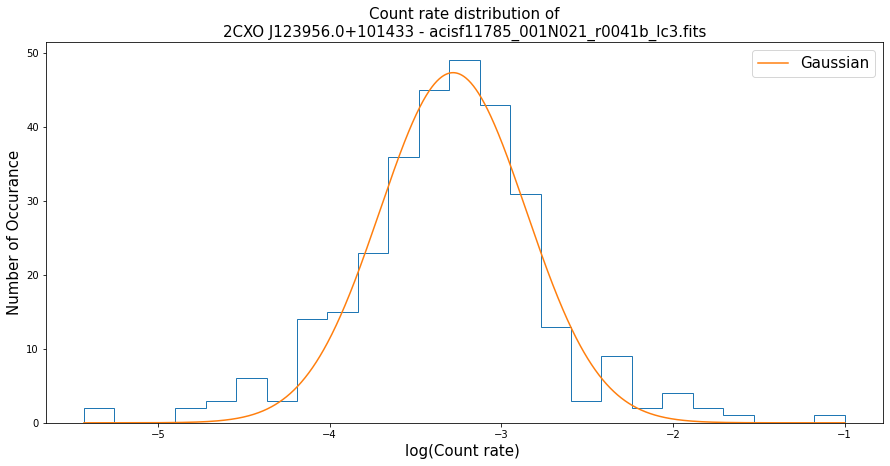

In [61]:
plt.figure(figsize = [15,7], facecolor = 'w')
distribution = plt.hist(sorted_count_rate[:], bins = 25, histtype = 'step')
x = []
y = []
for i in range(len(distribution[0])):
    x_temp = np.linspace(distribution[1][i], distribution[1][i+1], 50)
    for j in range(len(x_temp)):
        x.append(x_temp[j])
        y.append(distribution[0][i])

def gaussian(x,a,b,c):
    exponent = -((x-b)**2/(2*c**2))
    return a*np.exp(exponent)

def lorrentzian(x,a,gamma,x_0):
    fraction = (gamma)/((x-x_0)**2 + (0.5*gamma)**2)
    result = a*fraction
    return result

param_g, pcov_g = curve_fit(gaussian, x,y)
param_l, pcov_l = curve_fit(lorrentzian, x,y)
plt.plot(x,gaussian(x,param_g[0],param_g[1],param_g[2]), label = 'Gaussian')
#plt.plot(x,lorrentzian(x,param_l[0],param_l[1],param_l[2]), label = 'Lorrentzian')
#plt.xscale('logit')
plt.legend(fontsize = 15)
plt.xlabel('log(Count rate) ', fontsize = 15)
plt.ylabel('Number of Occurance', fontsize = 15)
plt.title('Count rate distribution of\n2CXO J123956.0+101433 - acisf11785_001N021_r0041b_lc3.fits', fontsize = 15)
#plt.xlim(1.5e-3,2e-3)

least_sq_g = 0
for i in range(len(x)):
    least_sq_g += (gaussian(x[i],param_g[0],param_g[1],param_g[2])-y[i])**2

dof_g = len(x)-3
print(f'Goodness of fit for Gaussian {least_sq_g/dof_g} per dof')